# CLIP Exploration

OpenAI with the release CLIP provides the first zero-shot paper that actually works relatively well across many datasets. They claim it is not necessarily evaluated on domain adaptation as pure zero-shot aims to solve, but evaluates adaptation to datasets. With that, said the use of this method open up many possibilities across differing tasks. What impressed me is that it even worked for activity recognition. In the paper, they classify a single frame from each video. My curiosity has been peaked and I'm curious how well this works in classifying video sequences. Let's find out.

# Goals
- First explore what does prediction look like on exercise classification.
- Explore how exercise classification performs in a video frame by frame as time-series.

# References
1. https://github.com/openai/CLIP
2. https://openai.com/blog/clip/

In [4]:
COLAB = True

# Install Colab Dependencies

In [5]:
if COLAB:
    ! pip install ftfy pydantic pytube regex
    ! pip install opencv-python --upgrade
    ! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.1 MB/s eta 0:00:00
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu101 (from versions: 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0+rocm5.7, 2.2.1, 2.2.1+cpu, 2.2.1+cpu.cxx11.abi, 2.2.1+cu118, 2.2.1+cu121, 2.2.1+rocm5.6, 2.2.1+rocm5.7, 2.2.2, 2.2.2+cpu, 2.2.2+cpu.cxx11.abi, 2.2.2+cu118, 2.2.2+cu121, 2.2.2+rocm5.6, 2.2.2+rocm5.7, 2.3.0, 2.3.0+cpu, 2.3.0+cpu.cxx11.abi, 2.3.0+cu118, 2.3.0+cu121, 2.3.0+rocm5.7, 2.3.0+rocm6.0, 2.3.1, 2.3.1+cpu, 2.3.1+cpu.cxx11.abi, 2.3.1+cu118, 2.3.1+cu121, 2.3.1+rocm5.7, 2.3.1+rocm6.0, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0)
ERROR: No matching distribution found for torch==1.7.1+cu101


# Imports

In [6]:
# Python imports
from enum import Enum
import itertools
from typing import Tuple, Any

# 3rd party imports
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Span
from bokeh.palettes import Dark2_5 as palette
from bokeh.plotting import figure, show
import cv2
import IPython.display
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pydantic import BaseModel
from pytube import YouTube
import requests
import skimage
import torch
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor

# Globals
colors_palette = itertools.cycle(palette)
output_notebook()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Torch version:", torch.__version__)

Torch version: 2.8.0+cu126


In [7]:
# Check which device available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Download the Model

CLIP models are distributed as TorchScript modules.


In [8]:
MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [9]:
! wget {MODELS["ViT-B/32"]} -O model.pt

--2025-10-21 07:47:48--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   109MB/s    in 3.1s    

2025-10-21 07:47:52 (109 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [ ]:
model = torch.jit.load("model.pt").to(device).eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print(
    "Model parameters:",
    f"{sum([int(torch.prod(torch.tensor(p.shape)).item()) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Processing

In [11]:
image_mean = [0.48145466, 0.4578275, 0.40821073]
image_std = [0.26862954, 0.26130258, 0.27577711]
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std),
])

# Text Preprocessing

CLIP uses a case-insensitive tokenizer. The tokenizer code is hidden in the second cell below

In [12]:
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2025-10-21 07:48:04--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.40, 13.107.213.40, 2620:1ec:bdf::40, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.1s    

2025-10-21 07:48:04 (9.70 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [13]:
# @title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1))
        + list(range(ord("¡"), ord("¬") + 1))
        + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2 ** 8):
        if b not in bs:
            bs.append(b)
            cs.append(2 ** 8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split("\n")
        merges = merges[1 : 49152 - 256 - 2 + 1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v + "</w>" for v in vocab]
        for merge in merges:
            vocab.append("".join(merge))
        vocab.extend(["<|startoftext|>", "<|endoftext|>"])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {
            "<|startoftext|>": "<|startoftext|>",
            "<|endoftext|>": "<|endoftext|>",
        }
        self.pat = re.compile(
            r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""",
            re.IGNORECASE,
        )

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + (token[-1] + "</w>",)
        pairs = get_pairs(word)

        if not pairs:
            return token + "</w>"

        while True:
            bigram = min(pairs, key=lambda pair: self.bpe_ranks.get(pair, float("inf")))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word) - 1 and word[i + 1] == second:
                    new_word.append(first + second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = " ".join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = "".join(self.byte_encoder[b] for b in token.encode("utf-8"))
            bpe_tokens.extend(
                self.encoder[bpe_token] for bpe_token in self.bpe(token).split(" ")
            )
        return bpe_tokens

    def decode(self, tokens):
        text = "".join([self.decoder[token] for token in tokens])
        text = (
            bytearray([self.byte_decoder[c] for c in text])
            .decode("utf-8", errors="replace")
            .replace("</w>", " ")
        )
        return text

# Setting up input images and texts

In [28]:
image_urls = {
    "drop-squats": "https://s3.amazonaws.com/prod.skimble/assets/3910/skimble-workout-trainer-exercise-drop-squat-1_iphone.jpg",
    # "1.5-Method": "https://www.t-nation.com/system/publishing/articles/10005403/original/The-1.5-Method-for-Squats.png?1506723495",
    "maxresdefault": "https://i.ytimg.com/vi/a00itcPcfTg/maxresdefault.jpg",
    "body-squats": "https://www.bodbot.com/Images/exercises/hi-res/realname/bodyweight-squat---partial.jpg",
    "benefits": "https://cdn2.stylecraze.com/wp-content/uploads/2014/08/10-Best-Benefits-Of-Jumping-Jacks-Exercises-For-Your-Body.jpg",
    "kid": "https://i.pinimg.com/originals/7a/f1/f5/7af1f548886161a060ba6d0ccf83c38e.jpg",
    "woman-pushup": "https://cdn2.stylecraze.com/wp-content/uploads/2014/08/3.-Plank-Jacks.jpg",
    # "woamn-2-pushups": "https://www.runtastic.com/blog/wp-content/uploads/2019/02/how-to-do-first-push-up-thumbnail_blog_1200x800-3.jpg",
    "woman-plank": "https://post.greatist.com/wp-content/uploads/sites/2/2019/04/PlankFeature-1200x628.png",
    "male-pushup-1": "https://www.muscleandfitness.com/wp-content/uploads/2017/09/close-hand-pushup-1.jpg",
    "male-pushup-2": "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/701/images/no-pushup-plan-1492799761.jpg",
}

In [15]:
texts = [
  "a person standing",
  "a person repeating a squat",
  "a person repeating a jumping jack",
  "a person performing a plank",
]

In [23]:
vid = requests.get("https://s3.amazonaws.com/prod.skimble/assets/3910/skimble-workout-trainer-exercise-drop-squat-1_iphone.jpg").content

In [31]:
def download_image(url: str) -> np.ndarray:
  temp_file_name = "image_name.jpg"
  img_data = requests.get(url).content
  with open(temp_file_name, 'wb') as handler:
      handler.write(img_data)
  image = Image.open(temp_file_name).convert("RGB")
  os.remove(temp_file_name) # to save up space
  return image

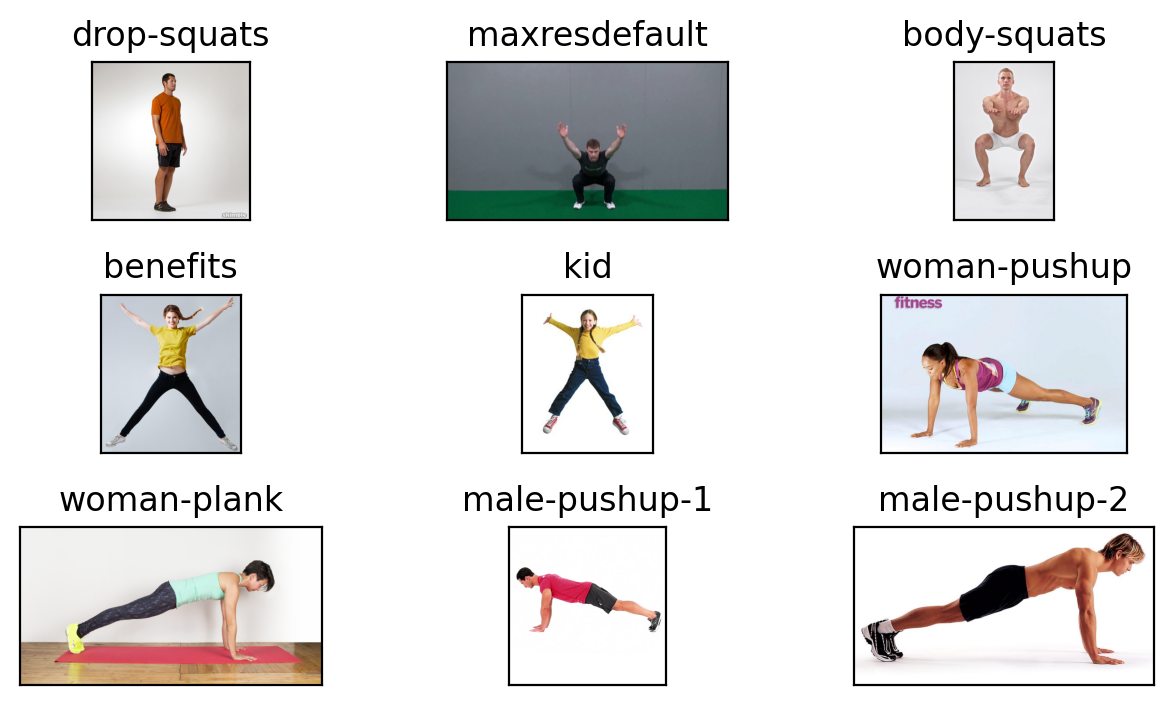

In [32]:
# Download and draw images
images = []
for id, url in image_urls.items():
    image = download_image(url)

    images.append(image)

    plt.subplot(4, 3, len(images))
    plt.imshow(image)
    plt.title(f"{id}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Prprocess images
norm_images = [preprocess(image) for image in images]

# Building features and Calculating cosine similarity followed by softmax

We use CLIP to normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

We normalize the features and calculate the dot product of each pair. Then compute the softmax of the distances.

In [33]:
from typing import List
def predict_images(images: List, labels: List) -> np.ndarray:
  image_input = torch.tensor(np.stack(images)).to(device)

  tokenizer = SimpleTokenizer()
  text_tokens = [tokenizer.encode("This is " + desc) for desc in labels]

  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  sot_token = tokenizer.encoder["<|startoftext|>"]
  eot_token = tokenizer.encoder["<|endoftext|>"]

  for i, tokens in enumerate(text_tokens):
      tokens = [sot_token] + tokens + [eot_token]
      text_input[i, : len(tokens)] = torch.tensor(tokens)

  text_input = text_input.to(device)

  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  probability = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy().T

  return probability

In [34]:
confidence = predict_images(norm_images, texts)

# Results on Images

It looks like performance is relatively good with most confusion between jumping jacks and squats. I had to engineer the text a bit to get better results. My iterations followed:
- "a person doing a..."
- "a person performing a"
- swapping between plural and singular
- after lookin in a thesaurus I tried "repeating"

The results didn't shift a lot, but enough for me to settle on the final wording. I'm sure part of the "prompt engineering" requires an exhaustive search over a dictionary of words and a standard validation set.

Text(0.5, 1.0, 'Confidence between text and image features')

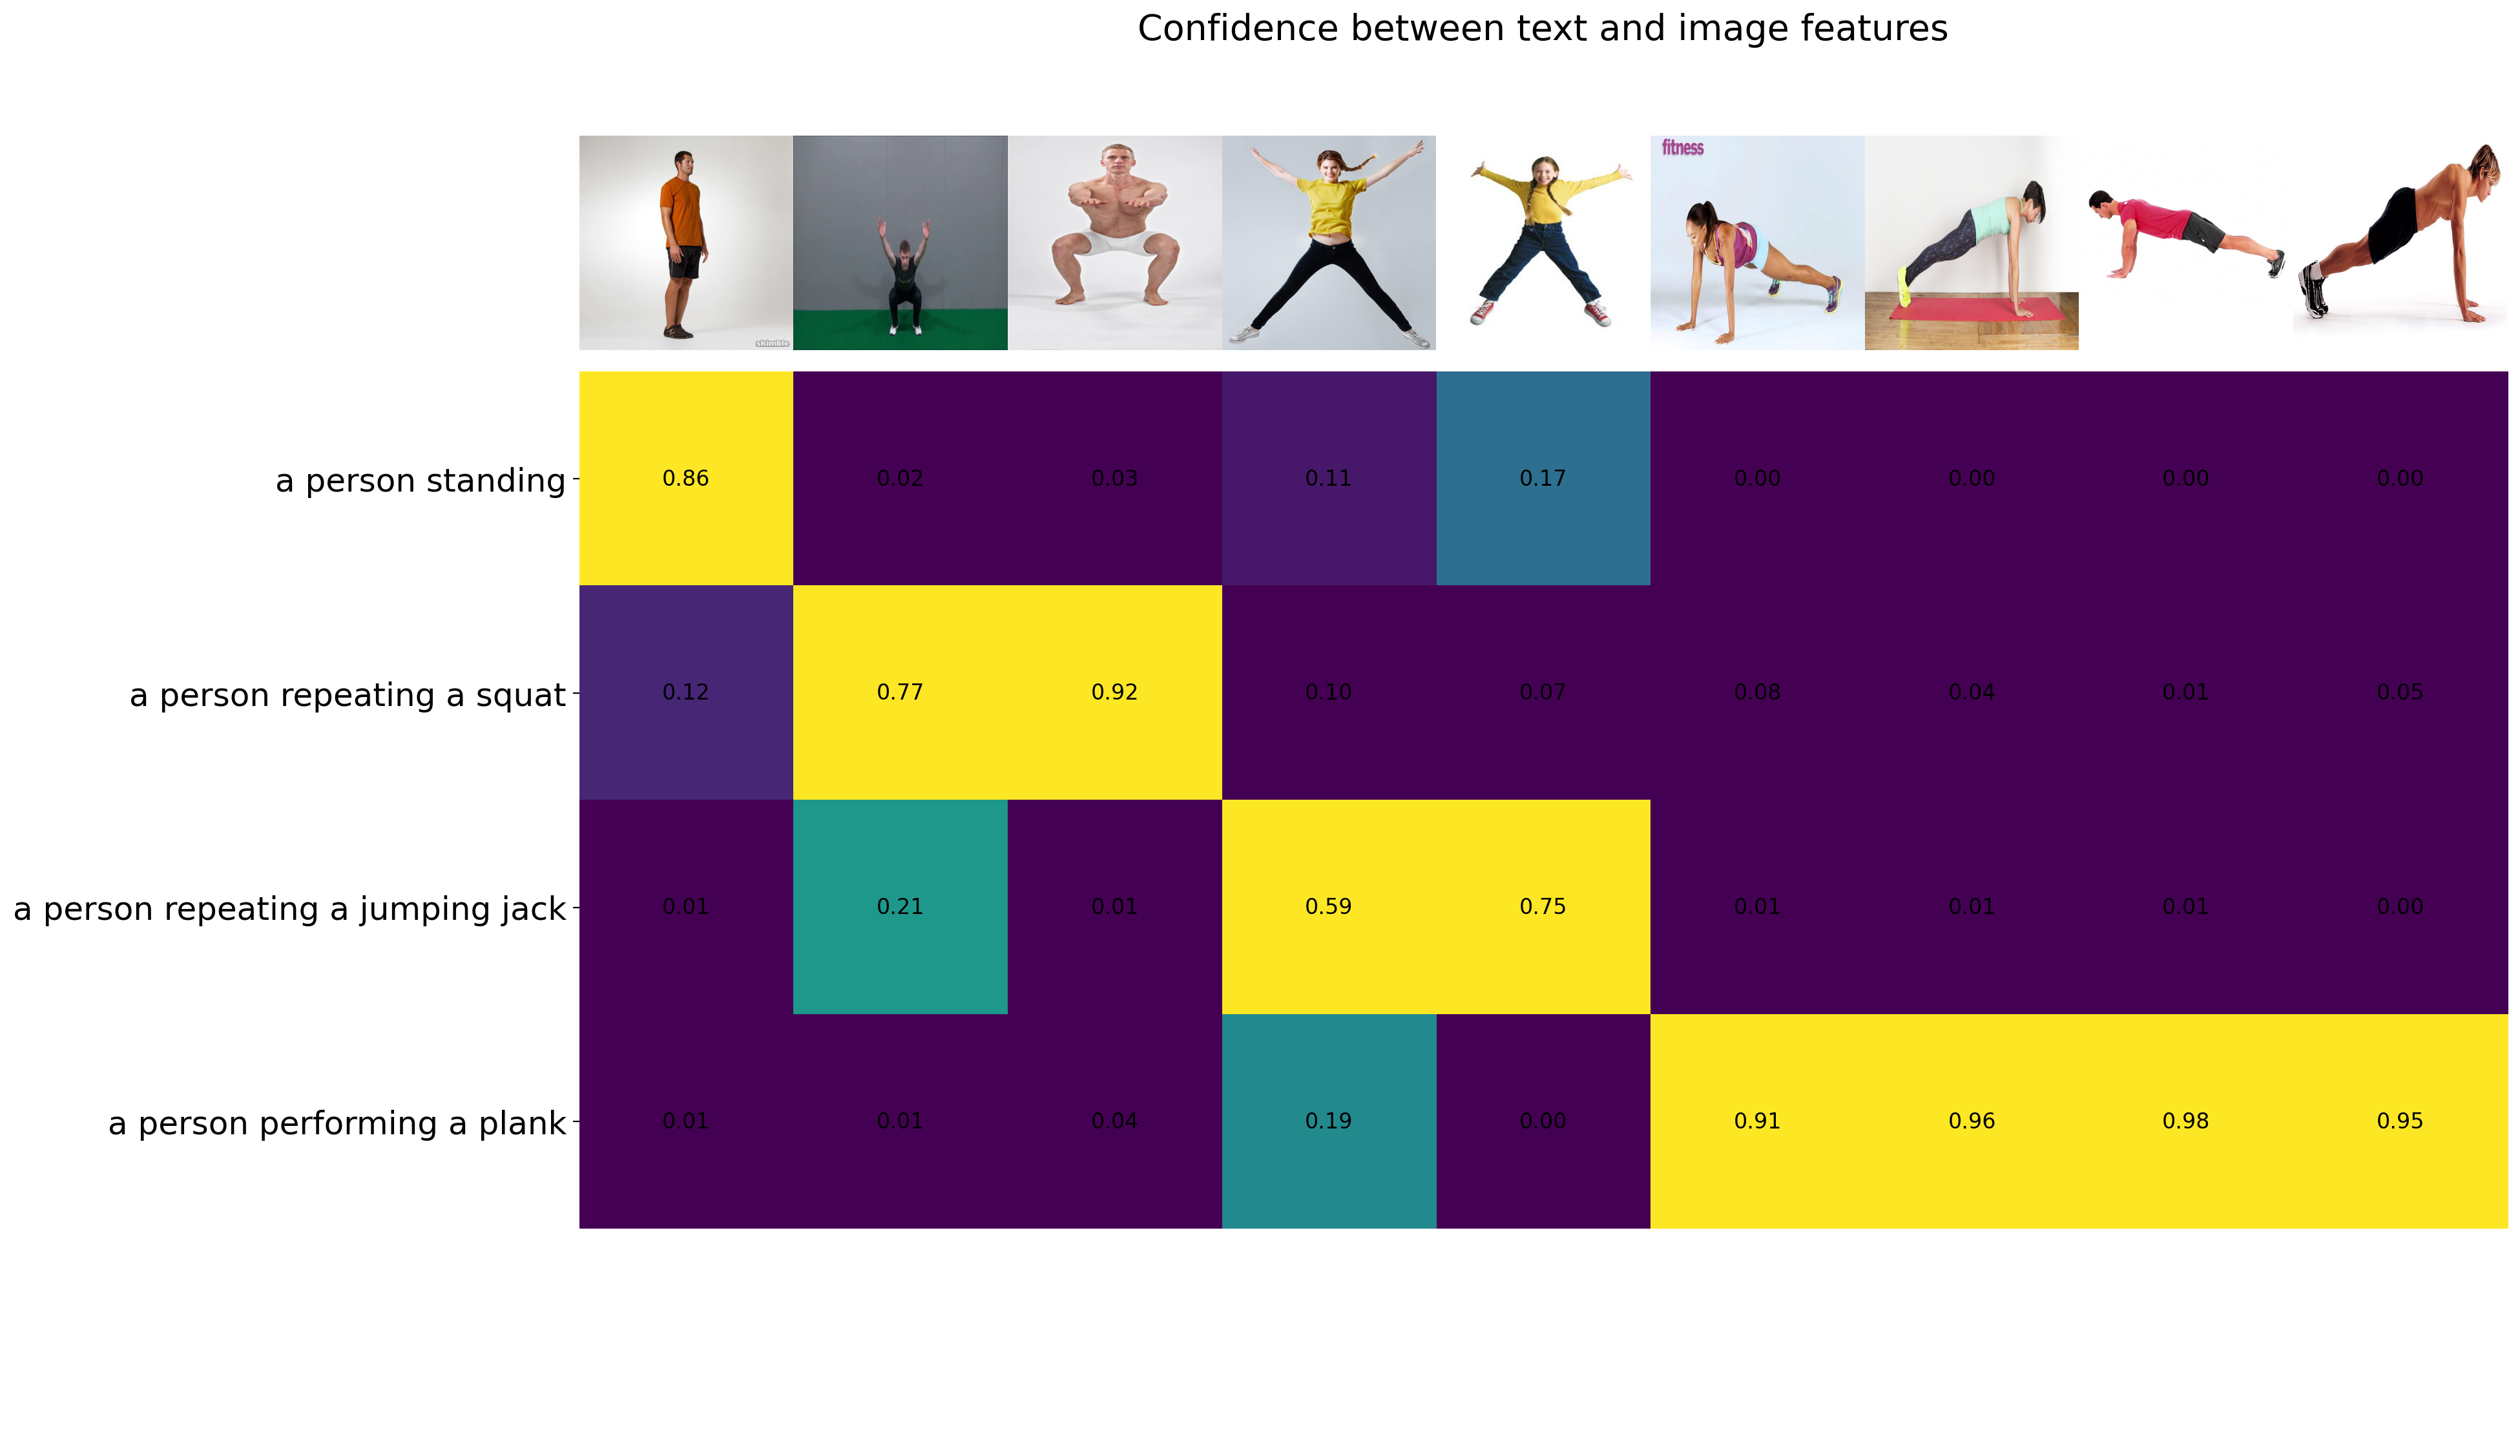

In [35]:
count = len(images)

plt.figure(figsize=(20, 14))
plt.imshow(confidence, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(len(texts)), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(confidence.shape[1]):
    for y in range(confidence.shape[0]):
        plt.text(x, y, f"{confidence[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([len(texts) + 0.5, -2])

plt.title("Confidence between text and image features", size=20)

# Video classes: Video reader, writer and base classes.

In [36]:


class VideoDataExample(BaseModel):
  name: str
  data: Any
  url: str = None

class VideoReader:
  def __init__(self, video_file_path: str):
    self.video_file_path = video_file_path
    self.capture = cv2.VideoCapture(video_file_path)
    self.width  = int(self.capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    self.height = int(self.capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    self.fps = self.capture.get(cv2.CAP_PROP_FPS)
    self.total_frames = self.capture.get(cv2.CAP_PROP_FRAME_COUNT)
    self.frame_count = -1

  def read(self) -> np.ndarray:
    ret, frame = self.capture.read()

    if ret:
      self.frame_count += 1
      return frame

    return None

  def __del__(self):
    self.capture.release()

class VideoWriter:
  def __init__(self,
               video_file_path: str,
               width: int,
               height: int,
               fps: int,
               codec: cv2.VideoWriter_fourcc = cv2.VideoWriter_fourcc(*"mp4v")
  ):
    self.writer = cv2.VideoWriter(
        video_file_path,
        codec,
        fps,
        (width, height)
    )
    self.width = int(width)
    self.height = int(height)
    self.codec = codec
    self.fps = fps

  def write(self, frame: np.ndarray):
    self.writer.write(frame)

  def __del__(self):
    self.writer.release()

# Download youtube video and process frames in a video in small batches.

In [37]:
 def download_yt_video(video_url: str):
  stream = YouTube(video_url).streams.first()
  stream.download()

  return stream.default_filename


def opencv_to_pil(image: np.ndarray):
  # You may need to convert the color.
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(image)
  return im_pil


def recognize_video(video_path: str, labels: List[str]) -> np.ndarray:
  video_reader = VideoReader(video_path)

  frames = []
  results = None
  while True:
    frame = video_reader.read()
    if frame is None:
      break

    frames.append( preprocess( opencv_to_pil(frame) ) )

    # after grabbing small batch, process images
    if len(frames) == 10:
      predictions = predict_images(frames, labels)

      # stack predictions for further analysis later
      if results is None:
        results = predictions
      else:
        results = np.hstack((results, predictions))
      frames = []

  # make sure we don't miss any results
  if len(frames) > 1:
    predictions = predict_images(frames, labels)
    if results is None:
      results = predictions
    else:
      results = np.hstack((results, predictions))

  # shove results in a class for easier passing around
  video_example = VideoDataExample(name=video_path, data=results)

  return video_example


# process a youtube video: download, process, and store
def process_youtube_video(video_url: str, labels: List[str]):
  video_filename = download_yt_video(video_url)
  video_example = recognize_video(video_filename, labels)
  video_example.url = video_url

  return video_example


# Prost processing of results for visualization

In [38]:
def moving_average(x, window_size=3):
  return np.convolve(x, np.ones(window_size), 'same') / window_size


def display_data_as_time_series(
    example: VideoDataExample,
    labels: List[str],
    frame_range: Tuple[(int, int)]=None,
    smoothing_window_size: int=3,
    confidence_threshold: float = 0,
):

  if frame_range is None:
    start_frame = example.data.shape[0]
    end_frame = example.data.shape[1]
  else:
    start_frame, end_frame = frame_range

  df = example.data
  time = np.arange(start_frame, end_frame) /30 /60

  # Hover tool parameters
  hover = HoverTool(
      tooltips=[("x,y", "($x, $y)")],
      point_policy="snap_to_data",
      line_policy="none",
      mode="vline",
  )

  # Figure tools
  #     tools = ["crosshair, pan, wheel_zoom, box_zoom, reset, box_select, lasso_select", hover]

  # Generate figure parameters
  title = example.name
  plot_width = 1000
  plot_height = 600

  x_range = None
  xaxis_label = "Time [frames]"
  yaxis_label = "Value"

  # Create figure
  p = figure(
      plot_width=plot_width,
      plot_height=plot_height,
      x_range=x_range,
      title=title,
      tooltips=[("x,y", "(@x, @y)")],
  )

  for (ind, tag), color in zip(enumerate(labels), colors_palette):
    # get data points to plot
    values = example.data[ind, start_frame:end_frame].copy()
    values = moving_average(values, window_size=smoothing_window_size)
    values[values <= confidence_threshold] = 0

    p.line(time, values, line_width=1, color=color, legend_label=tag)

  p.legend.location = "bottom_right"
  p.legend.click_policy = "hide"
  p.xaxis.axis_label = xaxis_label
  p.yaxis.axis_label = yaxis_label

  show(p)

In [ ]:
class Colors:
  red: Tuple[int, int, int] = (77, 77, 255)
  blue: Tuple[int, int, int] = (255, 51, 51)
  green: Tuple[int, int, int] = (77, 230, 0)
  yellow: Tuple[int, int, int] = (128, 255, 255)


def draw_text(image: torch.Tensor, text: str, color: Tuple[int, int, int], location: Tuple[int, int]):
  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 0.8
  thickness = 2
  image = cv2.putText(image, text, location, font,
                   fontScale, color, thickness, cv2.LINE_AA)
  return image

def make_decision(predictions: np.ndarray, labels: List[str], confidence_threshold: float):
  match_ind = np.argmax(predictions)
  if predictions[match_ind] >= confidence_threshold:
    decision = labels[match_ind]
  else:
    decision = labels[0]

  return decision

def draw_results(video_example: VideoDataExample, output_filename: str, labels: List[str], confidence_threshold: float = 0.5):
  video_reader = VideoReader(video_example.name)
  video_writer = VideoWriter(output_filename, video_reader.width, video_reader.height, video_reader.fps)
  probabilities = video_example.data.copy()

  # smooth results
  for i in range(probabilities.shape[0]):
    probabilities[i,:] = moving_average(probabilities[i,:], 5)

  while True:
    frame = video_reader.read()

    if frame is None:
      break

    # make decision
    current_pred = probabilities[:, video_reader.frame_count]
    prediction_text = make_decision(current_pred, labels, confidence_threshold)

    # Draw
    frame = draw_text(frame, prediction_text, Colors.red, (10, 20))

    # write frame
    video_writer.write(frame)

# Example Video Output

Grab and dump YouTube video of man doing a burpee in a living room. The recognizer does well detecting when he is standing up and on the ground as plank position. There is a little confusion between jumping jacks and squats. However, I would say the method performs relatively well not tuned for activity recognition.

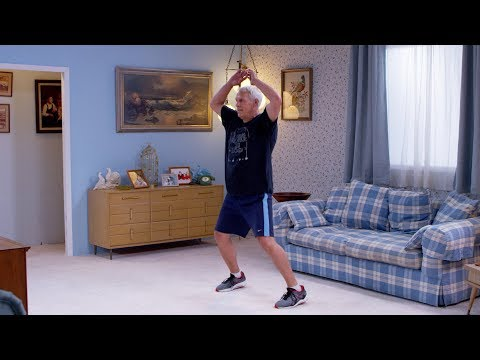

In [40]:
youtube_id = "BkzTOA4t8ME"
youtube_video_url = f"https://www.youtube.com/watch?v={youtube_id}"
YouTubeVideo(youtube_id)

In [41]:
video_example = process_youtube_video(youtube_video_url, texts)

HTTPError: HTTP Error 400: Bad Request

In [ ]:
draw_results(video_example, "burpee_result.mp4", texts, confidence_threshold=0)

In [ ]:
display_data_as_time_series(video_example, texts, smoothing_window_size=5, confidence_threshold=0)

# Conclusions

The results are not horrible, but also not great. I am sure with a more exhaustive search better results could be obtained. There are a few avenues to explore for better performance.

## 1. Training free exercise lookup
- Collect a set of images representative of static positions in exercises.
- Monitor matches over time and make decisions in a time-series manner.

## 2. Training with CLIP model as teacher
- Collect a large enough dataset
- Learn classification model over the dataset.
- Use CLIP model as an additional loss guiding the model to learn similar features.

This is a bit different than simply fine-tuning the CLIP model might suffice, but it seems semi-supervised learning or distillation could do even better here and more interesting to explore.

## 3. Engineer the crap out of it :-D
I could see how adding motion, person, and/or pose detectors combined with this network could provide an ensemble of signals to make a better prediction. However, I lean towards doing heuristics after we've squeezed as much as we can out of an exhaustive data collection and analysis.

I guess it's all relative to what is your timeline and goals to determine what is the "good enough model".

I hope my superficial tests help someone out there.